# Modeling Procedure 

In principle, the neural network could be defined by graphs consist of tensors and trained through automatic differenciate.

However, for simplification, we recommend to use high-level Keras API in Tensorflow to implement the neural networks.

The common procedures of implementing neural networks using TensorFlow are:

1. Data preparation and loading
2. Model definition
3. Model training
4. Model evaluation, application and saving

In [1]:
import sys
import os
project_path = os.path.abspath(os.path.join(os.getcwd(), "../.."))
sys.path.append(project_path)
import numpy as np
import pandas as pd
import datetime
import re,string

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models,layers
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

from utils.dataset_loader import load_cifar10,get_txt_dataset_from_csv,structured_data_preprocessing,get_dataset_from_list_files
from utils.trainer import plot_metric
from backbone.cnn import CNN_3L, Sequential_CNN_3L

In [2]:
# 1 Dataset and dataloader
train_data_path = "../../data/imdb/train.csv"
test_data_path =  "../../data/imdb/test.csv"

MAX_WORDS = 10000  # Consider the 10000 words with the highest frequency of appearance
MAX_LEN = 200  # For each sample, preserve the first 200 words
BATCH_SIZE = 20 
ds_train, ds_test = get_txt_dataset_from_csv(train_data_path,test_data_path,MAX_WORDS = MAX_WORDS, MAX_LEN = MAX_LEN, BATCH_SIZE = BATCH_SIZE )
for x,y in ds_train.take(1): # ds_train = (x_train , y_train)
    print(x.shape,y.shape)

# 2 Model definition (Sequential, Model(Input,Output))
tf.keras.backend.clear_session()
class CnnModel(models.Model):
    def __init__(self):
        super(CnnModel, self).__init__()
        
    def build(self,input_shape):
        self.embedding = layers.Embedding(MAX_WORDS,7,input_length=MAX_LEN)
        self.conv_1 = layers.Conv1D(16, kernel_size= 5,name = "conv_1",activation = "relu")
        self.pool_1 = layers.MaxPool1D(name = "pool_1")
        self.conv_2 = layers.Conv1D(128, kernel_size=2,name = "conv_2",activation = "relu")
        self.pool_2 = layers.MaxPool1D(name = "pool_2")
        self.flatten = layers.Flatten()
        self.dense = layers.Dense(1,activation = "sigmoid")
        super(CnnModel,self).build(input_shape)
    
    def call(self, x):
        x = self.embedding(x)
        x = self.conv_1(x)
        x = self.pool_1(x)
        x = self.conv_2(x)
        x = self.pool_2(x)
        x = self.flatten(x)
        x = self.dense(x)
        return(x)
    
    # To show Output Shape
    def summary(self):
        x_input = layers.Input(shape = MAX_LEN)
        output = self.call(x_input)
        model = tf.keras.Model(inputs = x_input,outputs = output)
        model.summary()
    
model = CnnModel()
model.build(input_shape =(None,MAX_LEN))

# 3 Set optimizer and training
model.compile(optimizer="SGD", loss='binary_crossentropy',
            metrics=['accuracy'])

stamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
logdir = os.path.join('../../data', 'autograph', stamp)
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
history = model.fit(ds_train, epochs=10,
                    validation_data=ds_test, # Could just use y_test instead of validation_split=0.2,
                    callbacks = [tensorboard_callback],workers = 4)  
model.summary()

# 4 Model evaluation, application and saving

['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i', 'this', 'that', 'was', 'as', 'for', 'with', 'movie', 'but', 'film', 'on', 'not', 'you', 'his', 'are', 'have', 'be', 'he', 'one', 'its', 'at', 'all', 'by', 'an', 'they', 'from', 'who', 'so', 'like', 'her', 'just', 'or', 'about', 'has', 'if', 'out', 'some', 'there', 'what', 'good', 'more', 'when', 'very', 'she', 'even', 'my', 'no', 'would', 'up', 'time', 'only', 'which', 'story', 'really', 'their', 'were', 'had', 'see', 'can', 'me', 'than', 'we', 'much', 'well', 'get', 'been', 'will', 'into', 'people', 'also', 'other', 'do', 'bad', 'because', 'great', 'first', 'how', 'him', 'most', 'dont', 'made', 'then', 'them', 'films', 'movies', 'way', 'make', 'could', 'too', 'any']
(20, 200) (20, 1)
Epoch 1/10
      1/Unknown - 0s 161us/step - loss: 0.6920 - accuracy: 0.6000WARNING:tensorflow:From /rds/user/hpczeji1/hpc-work/anaconda3/envs/py36/lib/python3.6/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tenso

In [3]:
## 4.1 Model evaluate 
model.evaluate(ds_test)  # Val_loss,val_accuracy， input ds_test instead of x = x_test,y = y_test

## 4.2 Model application
model.predict(ds_test)  # Predict the possiblities
for x,y in ds_test.take(1):
    print(model.predict_on_batch(x[0:20]))


250/250 [==============================] - 0s 2ms/step - loss: 0.6900 - accuracy: 0.5294
[[0.49204546]
 [0.49631104]
 [0.4967426 ]
 [0.4944859 ]
 [0.485171  ]
 [0.48103914]
 [0.48015967]
 [0.4947515 ]
 [0.51329803]
 [0.48995128]
 [0.4921977 ]
 [0.4823234 ]
 [0.4896854 ]
 [0.48626631]
 [0.48174638]
 [0.49675718]
 [0.48342738]
 [0.4929095 ]
 [0.48067582]
 [0.48197347]]


In [4]:
## 4.3 Model saving
model.save('../../model_saved/image_data_keras_model.model') 
del model  #Deleting current model
model = models.load_model('../../model_saved/structured_data_keras_model.model')

# Could also model.to_json/models.model_from_json to save structure
# Could also model.save_weights, and save ckpt in save_format = "tf"

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ../../model_saved/image_data_keras_model.model/assets


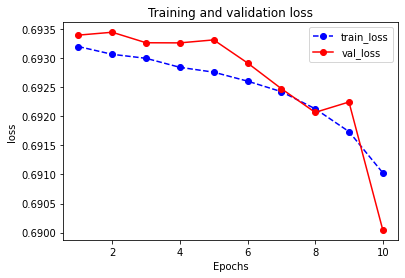

In [5]:
# 4 Model evaluation, application and saving
plot_metric(history,"loss")

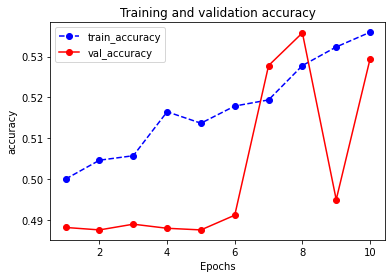

In [7]:
plot_metric(history,"accuracy")